In [2]:
import os
import random

import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from torch.utils.data import Dataset
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Define Helpers

In [3]:
def get_n_params(model):
    """ Function to count number of parameters in a model. """
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# For reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print('Manual seed changed successfully.')

seed = 42
seed_everything(seed)

Manual seed changed successfully.



## Load Raw Data and Define Datasets

  - MNIST  dataset is loaded, resized to (32x32) pixels, converted to tensors, and normalized.
  - The training set is then randomly split into training and validation sets.
  - PyTorch DataLoaders are created for the training, validation, and test sets, enabling efficient batch loading during training.

  - The function returns the original training set, training DataLoader, validation set, validation DataLoader, test set, and test DataLoader.


In [4]:
def load_data(train_batch_size, test_batch_size):
    trainset = datasets.MNIST('../Datasets/', train=True, download=True,
                               transform=transforms.Compose([
                               transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                               ]))

    val_set_size = int(0.2 * len(trainset))
    trainset, valset = torch.utils.data.random_split(trainset, [len(trainset) - val_set_size, val_set_size])

    testset = datasets.MNIST('../Datasets', train=False,
                              transform=transforms.Compose([
                                  transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=train_batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

    return trainset, train_loader, valset, val_loader, testset, test_loader

In [5]:
train_batch_size = 64
test_batch_size = 1000

train_set, train_loader, val_set, val_loader, test_set, test_loader = load_data(train_batch_size, test_batch_size)

print(f'data shape: train {len(train_set)}, val {len(val_set)}, test {len(test_set)}')

data shape: train 48000, val 12000, test 10000


## Display some images


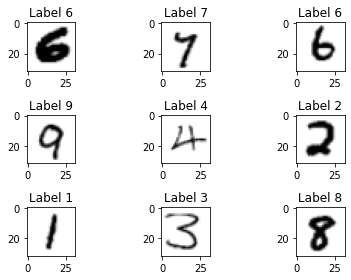

In [6]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(255 - train_set[i][0].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(f"Label {train_set[i][1]}")
plt.tight_layout()
plt.show()


## Model Definition

In [7]:
class CNN(nn.Module):
    def __init__(self, n_feat_maps):
        super(CNN, self).__init__()
        self.n_feat_maps = n_feat_maps
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feat_maps, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feat_maps, n_feat_maps, kernel_size=5)
        self.fc1 = nn.Linear(n_feat_maps*5*5, 50)
        self.fc2 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

## Training and Evaluation Functions

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Working on: ', device)

total_train_accuracy, total_val_accuracy = [], []
total_train_loss, total_val_loss = [], []

criterion = torch.nn.CrossEntropyLoss()

def train(epoch, model):

    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.data
        loss.backward()
        optimizer.step()
        preds = output.data.max(1, keepdim=True)[1]
        correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()

        if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    total_train_accuracy.append(accuracy)
    total_train_loss.append(train_loss)


def eval(model):

    model.eval()
    val_loss = 0
    correct = 0


    for data, target in tqdm(val_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data  # sum up batch loss
        preds = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    total_val_accuracy.append(accuracy)
    total_val_loss.append(val_loss)


    print('\nValidation set: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        accuracy))

def test(model,loader):
    model.eval()
    predictions = []

    for data, target in tqdm(loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.data.max(1, keepdim=True)[1]
        predictions.append(preds.tolist())

    flat_predictions = []
    for lst in predictions:
        flat_predictions += lst

    return flat_predictions

Working on:  cpu


### Train and Evaluate a Model

In [8]:
# define number of feature maps
n_feat_maps = 3

model_cnn = CNN(n_feat_maps)
model_cnn.to(device)

optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
for epoch in range(0, 5):
    train(epoch, model_cnn)
    eval(model_cnn)

Number of parameters: 4616
Train Epoch: 0 [0/48000 (0%)]	Loss: 2.299714
Train Epoch: 0 [6400/48000 (13%)]	Loss: 2.278787
Train Epoch: 0 [12800/48000 (27%)]	Loss: 0.997551
Train Epoch: 0 [19200/48000 (40%)]	Loss: 0.551649
Train Epoch: 0 [25600/48000 (53%)]	Loss: 0.672357
Train Epoch: 0 [32000/48000 (67%)]	Loss: 0.389611
Train Epoch: 0 [38400/48000 (80%)]	Loss: 0.476584
Train Epoch: 0 [44800/48000 (93%)]	Loss: 0.416331


100%|██████████| 188/188 [00:03<00:00, 57.95it/s]



Validation set: average loss: 0.0048, accuracy: 10985/12000 (92%)

Train Epoch: 1 [0/48000 (0%)]	Loss: 0.196317
Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.346204
Train Epoch: 1 [12800/48000 (27%)]	Loss: 0.653446
Train Epoch: 1 [19200/48000 (40%)]	Loss: 0.452342
Train Epoch: 1 [25600/48000 (53%)]	Loss: 0.201095
Train Epoch: 1 [32000/48000 (67%)]	Loss: 0.384506
Train Epoch: 1 [38400/48000 (80%)]	Loss: 0.217926
Train Epoch: 1 [44800/48000 (93%)]	Loss: 0.079533


100%|██████████| 188/188 [00:03<00:00, 55.54it/s]



Validation set: average loss: 0.0032, accuracy: 11262/12000 (94%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.334016
Train Epoch: 2 [6400/48000 (13%)]	Loss: 0.310620
Train Epoch: 2 [12800/48000 (27%)]	Loss: 0.177576
Train Epoch: 2 [19200/48000 (40%)]	Loss: 0.102925
Train Epoch: 2 [25600/48000 (53%)]	Loss: 0.194067
Train Epoch: 2 [32000/48000 (67%)]	Loss: 0.040635
Train Epoch: 2 [38400/48000 (80%)]	Loss: 0.168648
Train Epoch: 2 [44800/48000 (93%)]	Loss: 0.173574


100%|██████████| 188/188 [00:03<00:00, 59.19it/s]



Validation set: average loss: 0.0024, accuracy: 11455/12000 (95%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.075269
Train Epoch: 3 [6400/48000 (13%)]	Loss: 0.279725
Train Epoch: 3 [12800/48000 (27%)]	Loss: 0.274016
Train Epoch: 3 [19200/48000 (40%)]	Loss: 0.117905
Train Epoch: 3 [25600/48000 (53%)]	Loss: 0.094444
Train Epoch: 3 [32000/48000 (67%)]	Loss: 0.115548
Train Epoch: 3 [38400/48000 (80%)]	Loss: 0.294270
Train Epoch: 3 [44800/48000 (93%)]	Loss: 0.189197


100%|██████████| 188/188 [00:03<00:00, 58.27it/s]



Validation set: average loss: 0.0021, accuracy: 11529/12000 (96%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 0.033304
Train Epoch: 4 [6400/48000 (13%)]	Loss: 0.181011
Train Epoch: 4 [12800/48000 (27%)]	Loss: 0.219783
Train Epoch: 4 [19200/48000 (40%)]	Loss: 0.168864
Train Epoch: 4 [25600/48000 (53%)]	Loss: 0.133277
Train Epoch: 4 [32000/48000 (67%)]	Loss: 0.151264
Train Epoch: 4 [38400/48000 (80%)]	Loss: 0.052923
Train Epoch: 4 [44800/48000 (93%)]	Loss: 0.059059


100%|██████████| 188/188 [00:03<00:00, 52.46it/s]


Validation set: average loss: 0.0020, accuracy: 11545/12000 (96%)



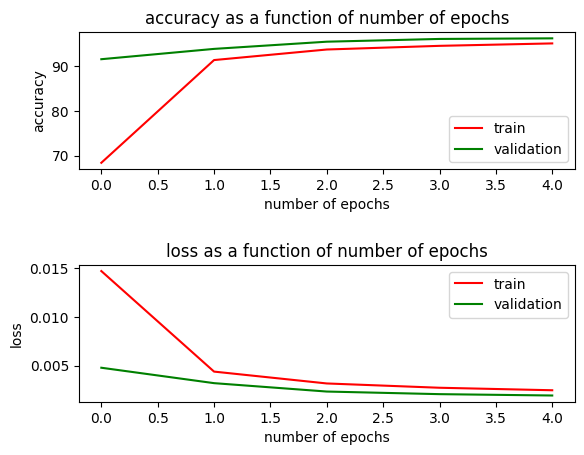

In [9]:
def plot_a_graph(x, y, z, x_title, y_title):
    plt.plot(x,y,color='r',label='train')
    plt.plot(x,z,color='g',label='validation')
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.legend()
    plt.title('{} as a function of {}'.format(y_title,x_title))
num_epoch =[0,1,2,3,4]
x_title = 'number of epochs'
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.7)
plot_a_graph(num_epoch,total_train_accuracy,total_val_accuracy,x_title,'accuracy')
plt.subplot(2,1,2)
plot_a_graph(num_epoch,total_train_loss,total_val_loss,x_title,'loss')


### Inference

In [10]:
test_predictions = test(model_cnn,test_loader)
print(test_predictions)


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

[[7], [2], [1], [0], [4], [1], [4], [9], [5], [9], [0], [6], [9], [0], [1], [5], [9], [7], [8], [4], [9], [6], [6], [5], [4], [0], [7], [4], [0], [1], [3], [1], [3], [4], [7], [2], [7], [1], [2], [1], [1], [7], [4], [2], [3], [5], [1], [2], [4], [4], [6], [3], [5], [5], [6], [0], [4], [1], [9], [5], [7], [8], [5], [3], [7], [4], [6], [4], [3], [0], [7], [0], [2], [7], [1], [7], [3], [2], [9], [7], [7], [6], [2], [7], [8], [4], [7], [3], [6], [1], [3], [6], [9], [3], [1], [4], [1], [7], [6], [9], [6], [0], [5], [4], [9], [9], [2], [1], [9], [4], [8], [7], [3], [9], [7], [4], [4], [4], [9], [2], [5], [4], [7], [6], [7], [9], [0], [5], [8], [5], [6], [6], [5], [7], [8], [1], [0], [1], [6], [4], [6], [7], [3], [1], [7], [1], [8], [2], [0], [2], [9], [8], [5], [5], [1], [5], [6], [0], [3], [4], [4], [6], [5], [4], [6], [5], [4], [5], [1], [4], [4], [7], [2], [3], [2], [7], [1], [8], [1], [8], [1], [8], [5], [0], [8], [9], [2], [5], [0], [1], [1], [1], [0], [9], [0], [3], [1], [6], [4], [2],

In [11]:
def plot_cm (predictions,y_true,title) :
    from sklearn.metrics import confusion_matrix
    matrix = confusion_matrix(y_true, predictions, normalize = 'all')
    disp = ConfusionMatrixDisplay(matrix).plot(cmap='Greys')
    fig = disp.ax_.get_figure()
    fig.set_figwidth(9)
    fig.set_figheight(9)
    plt.title ('confusion matrix for {} set'.format(title))


100%|██████████| 188/188 [00:03<00:00, 59.92it/s]


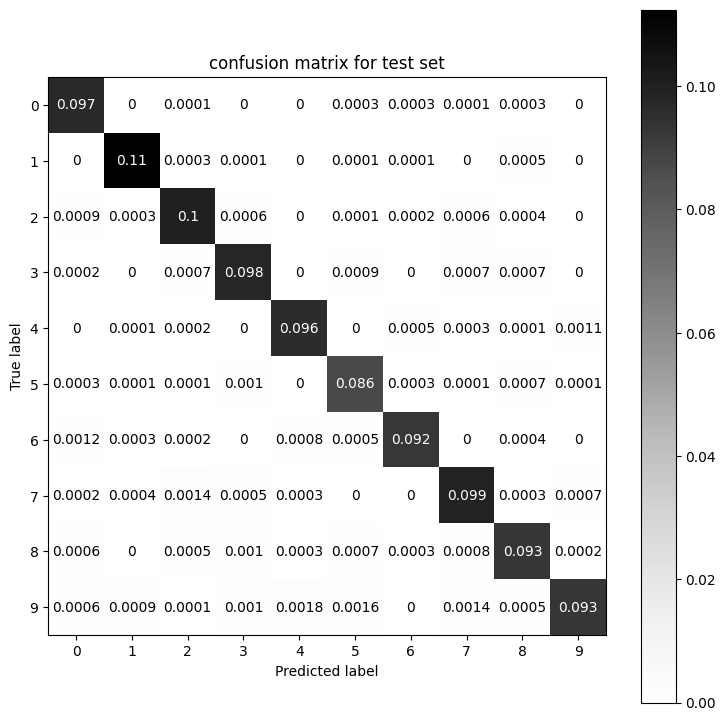

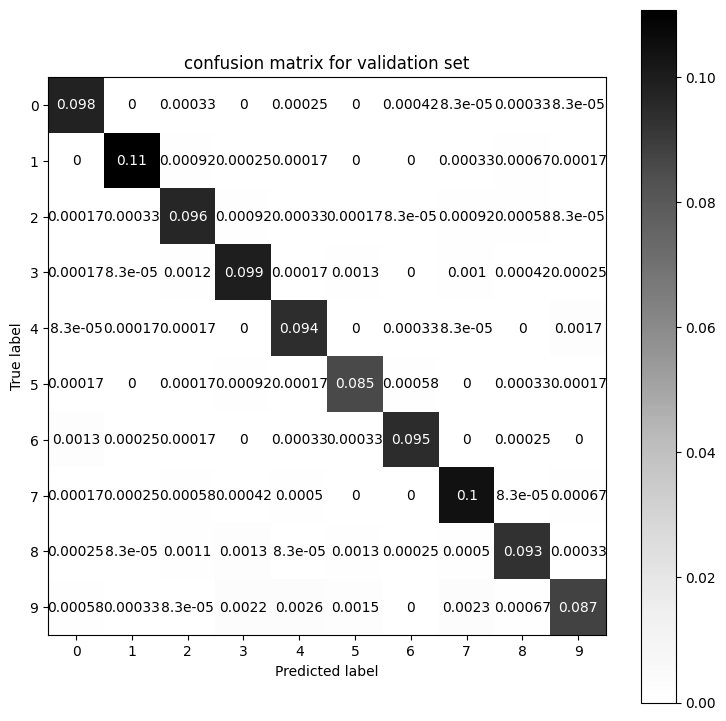

In [12]:
y_true_test = test_set.targets
y_true_val = []
y_true = []
for data, target in tqdm(val_loader):
    y_true.append(target)
for tensor in y_true:
    for item in tensor :
        y_true_val.append(item)
val_predictions = test(model_cnn,val_loader)

#ploting confusion matrix for each set
plot_cm(test_predictions,y_true_test,'test')
plot_cm(val_predictions,y_true_val,'validation')

we can see that the accuracy of the validation is a little bit better than the test accuracy that is because we might done overfitting to the data. Therefore the use of dropout can reduce the overfitting

In [120]:
y_true_test = test_set.targets.numpy()
def calculate_accuracy (loader,predictions,y_true):
    correct = 0
    for i in range(len(predictions)) :
        correct += predictions[i] == y_true[i]
    accuracy = 100. * correct / len(loader.dataset)
    print('accuracy is :{}'.format(accuracy))
    return accuracy
calculate_accuracy(test_loader,test_predictions,y_true_test)
#accuracy without dropout

accuracy is :[96.26]


array([96.26])

In [132]:
y_true_test = test_set.targets.numpy()
calculate_accuracy(test_loader,test_predictions,y_true_test)

accuracy is :[97.23]


array([97.23])

as we can see accuracy without drop out (96.26) is lower than the one with drop out (97.23) so we can understand that the model was a bit over fitting and drop out layer halped it